# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [155]:
# your code here
impurity_type = 'entropy'

def impurity(labels,loss_type='entropy'):
    c_pos = 0
    c_neg = 0
    for label in labels:
        if label==1:
            c_pos+=1
        else:
            c_neg+=1
        
    p = float(c_pos)/float(c_pos+c_neg)

    # print("Len ",len(x))
    if loss_type=='entropy':
        if p==0 or p==1:
            return 0
        return 0-(p*np.log2(p)+(1-p)*np.log2(1-p))
    elif loss_type=='gini':
        return 1-(p*p+(1-p)*(1-p))
    elif loss_type=='misclassific':
        p = p if (c_neg>c_pos) else 1-p
        return p
    elif loss_type=='log_loss':
        if p==0 or p==1:
            return 0
        p = p if (c_neg<=c_pos) else 1-p
        return 0-(p*np.log2(p))

def delta(x,threshold,feature):
    c_pos = 0
    c_neg = 0
    u_pos = 0
    u_neg = 0
    label = x[:,-1]
    before = impurity(label,loss_type="gini")
    if before==0:
        return 0,0,0   #pure node
    left_node = []
    right_node = []
    for i,banknote in enumerate(x):
        if banknote[feature]<threshold:
            left_node.append(label[i])
        else:
            right_node.append(label[i])
        
    n = float(len(x))
    after = (float(len(left_node))/n)*impurity(left_node,loss_type="gini")+(float(len(right_node))/n)*impurity(right_node,loss_type="gini")
    return after-before,before,after
    # print("Len ",len(x))
    


### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [157]:
# your code here

features = ['var','skew','curt','ent']
def decision_tree(X_train,depth=3):
    mn = 0
    
    X_set = [X_train]
    ordered = []
    val, count = np.unique(X_train[:,-1],return_counts=True)
    if len(val)==1:
        counter = [count[0],0] if val[0]==0 else [0,count[0]]
    else:
        counter = count
    prev = [counter]
    for level in range(depth):  #3 levels deep
        min_feature = 1e6
        pred = [-1]*(2**(level+1))
        for i,feature in enumerate(features):
            net_impurity = 0
            decision_boundary = []
            for X in X_set:
                if X is not None:
                    mn = 1e6
                    step = float(X[:,i].max()-X[:,i].min())/5.0
                    # B = None
                    # A = None
                    for boundary in np.arange(X[:,i].min()+step,X[:,i].max(),step):
                        imp,_,_ = delta(X,boundary,i)
                        # if (level>0):
                        # print(f"For {feature} at {boundary}, imp = {imp}")
                        if imp>0:
                            print("Erroneous")
                        if imp==0:
                            decision_boundary_node = None
                            # print("B4 ",b)
                            break
                        if imp<mn:
                            mn = imp
                            decision_boundary_node = boundary
                            # B,A = b,a
                    decision_boundary.append(decision_boundary_node)
                    net_impurity += mn
                else:
                    decision_boundary.append(None)

            if net_impurity<min_feature:
                selected = feature
                feature_index = i
                feature_boundary = decision_boundary
                min_feature = net_impurity
            
        print(f"At level {level}, choosing {selected} feature with a threshold = {feature_boundary}")
        ordered.append((selected,feature_boundary))
        
        features.remove(selected)
        X_new = []
        pred = []
        for i,X in enumerate(X_set):
            left = []
            right = []
            if feature_boundary[i]:
                for x in X: #x is a data sample
                    if x[feature_index]<=feature_boundary[i]:
                        left.append(x)
                    else:
                        right.append(x)
                left = np.delete(left, feature_index, axis=1)
                X_new.append(left)
                val, count = np.unique(left[:,-1],return_counts=True)
                if len(val)==1:
                    counter = [count[0],0] if val[0]==0 else [0,count[0]]
                else:
                    counter = count
                pred.append(counter)
                right = np.delete(right, feature_index, axis=1)
                X_new.append(right)
                val, count = np.unique(right[:,-1],return_counts=True)
                if len(val)==1:
                    counter = [count[0],0] if val[0]==0 else [0,count[0]]
                else:
                    counter = count
                pred.append(counter)
            else:
                X_new.append(None)
                X_new.append(None)
                pred.append(prev[i])
                pred.append([-1,-1])
            # X = np.delete(X, feature_index, axis=1)
        prev = pred
        
        X_set = X_new[:]
        if level==depth-1:
            imp = 0
            
            flag = True
            for X in X_new:
                if X is not None:
                    val, count = np.unique(X[:,-1],return_counts=True)
                    print("Count ",val,count)
                    imp += impurity(X[:,-1])
                else:
                    if flag:
                        print("None")
                        flag = False
                    else:
                        flag = True
                # if (count[0]>count[1])
            print("Final impurity = ",imp)

    predictor = []
    for x in pred:
        if (x[0]>x[1]):
            prediction = 0
        elif (x[0]<x[1]):
            prediction = 1 
        else:
            prediction = -1
        predictor.append(prediction)
    return ordered, predictor
            
#ACCURACY BELOW

### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

*Ans* <font color='red'>A decision tree regressor will enable to find the probability or some other score on an unknown banknote. Thus we have to annotate the training data with the probability of counterfeit and accordingly nodes along a decision path will contain the weightage of each of the 4 features that will give the probability value of the banknote.</font>

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [136]:
print(X_train.shape)

(1029, 5)


In [158]:
#OUR CLASSIFIER
ordered_classifier,predictor = decision_tree(X_train)
print(ordered_classifier)
print(predictor)

features = ['var','skew','curt','ent']
        

At level 0, choosing var feature with a threshold = [1.2780399999999998]
At level 1, choosing skew feature with a threshold = [7.606659999999996, 7.66752]
At level 2, choosing curt feature with a threshold = [-0.6434000000000006, -0.9406200000000005, -2.37768, None]
Count  [0. 1.] [  4 124]
Count  [0. 1.] [ 92 286]
Count  [0.] [41]
Count  [0. 1.] [57 17]
Count  [0. 1.] [15 13]
Count  [0. 1.] [276   5]
None
Final impurity =  2.9039712001856723
[('var', [1.2780399999999998]), ('skew', [7.606659999999996, 7.66752]), ('curt', [-0.6434000000000006, -0.9406200000000005, -2.37768, None])]
[1, 1, 0, 0, 0, 0, 0, -1]


In [143]:
print(X_train.shape,X_test.shape)
x_test = X_test[:,:4]
y_test = X_test[:,-1]
print(x_test.shape,y_test.shape)

(1029, 5) (343, 5)
(343, 4) (343,)


In [145]:
#SKLEARN CLASSIFIER

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


def prediction(X_test, clf_object):
	y_pred = clf_object.predict(X_test)
	return y_pred
	
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
	print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
	print ("Accuracy : ", accuracy_score(y_test,y_pred)*100)
	
	# print("Report : ",
	# classification_report(y_test, y_pred))

x_train = X_train[:,:4]
y_train = X_train[:,-1]
x_test = X_test[:,:4]
y_test = X_test[:,-1]
clf_entropy = DecisionTreeClassifier(
			criterion = "entropy", random_state = 100, max_depth = 3, min_samples_leaf = 5)
clf_entropy.fit(x_train, y_train)

clf_gini = DecisionTreeClassifier(
			criterion = "gini", random_state = 100, max_depth = 3, min_samples_leaf = 5)
clf_gini.fit(x_train, y_train)

clf_lloss = DecisionTreeClassifier(
			criterion = "log_loss", random_state = 100, max_depth = 3, min_samples_leaf = 5)
clf_lloss.fit(x_train, y_train)

print("Using Entropy:")
y_pred_entropy = prediction(x_test, clf_entropy)
cal_accuracy(y_test, y_pred_entropy)

print("Using Gini index:")
y_pred_gini = prediction(x_test, clf_gini)
cal_accuracy(y_test, y_pred_gini)

print("Using Log Loss:")
y_pred_lloss = prediction(x_test, clf_lloss)
cal_accuracy(y_test, y_pred_lloss)

Using Entropy:
Confusion Matrix:  [[152  26]
 [  1 164]]
Accuracy :  92.12827988338192
Using Gini index:
Confusion Matrix:  [[174   4]
 [ 30 135]]
Accuracy :  90.0874635568513
Using Log Loss:
Confusion Matrix:  [[152  26]
 [  1 164]]
Accuracy :  92.12827988338192


[Text(0.5, 0.875, 'x[0] <= -0.297\ngini = 0.491\nsamples = 1029\nvalue = [584, 445]'),
 Text(0.25, 0.625, 'x[1] <= 9.353\ngini = 0.259\nsamples = 425\nvalue = [65, 360]'),
 Text(0.125, 0.375, 'x[0] <= -0.459\ngini = 0.126\nsamples = 384\nvalue = [26, 358]'),
 Text(0.0625, 0.125, 'gini = 0.098\nsamples = 367\nvalue = [19, 348]'),
 Text(0.1875, 0.125, 'gini = 0.484\nsamples = 17\nvalue = [7, 10]'),
 Text(0.375, 0.375, 'x[0] <= -2.572\ngini = 0.093\nsamples = 41\nvalue = [39, 2]'),
 Text(0.3125, 0.125, 'gini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 36\nvalue = [36, 0]'),
 Text(0.75, 0.625, 'x[2] <= -4.386\ngini = 0.242\nsamples = 604\nvalue = [519, 85]'),
 Text(0.625, 0.375, 'x[0] <= 3.304\ngini = 0.368\nsamples = 37\nvalue = [9, 28]'),
 Text(0.5625, 0.125, 'gini = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(0.6875, 0.125, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]'),
 Text(0.875, 0.375, 'x[0] <= 1.592\ngini = 0.181\nsamples = 567\nvalue = [510, 57]

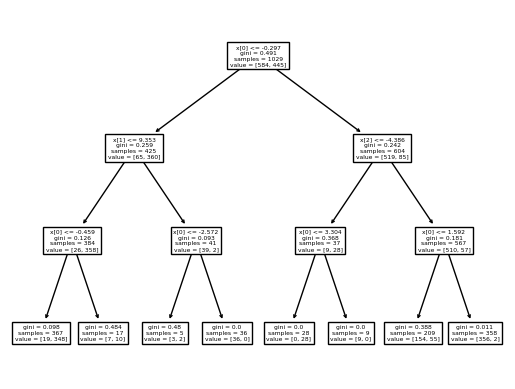

In [161]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

plot_tree(clf_gini)


#Feature [0], variance is reused in level 3

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [78]:

data = pd.read_csv('bankAuth.txt', names=features+['label'])
print(data.shape)
data.describe()

(1372, 5)


,var,skew,curt,ent,label
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [6]:
# your code here
import matplotlib.pyplot as plt
plt.plot()

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [111]:
# your code here
from sklearn.model_selection import train_test_split
x = data.values
# Y = data.values[:,4]
X_train, X_test = train_test_split(x, test_size=0.25)

In [112]:
print(X_train.shape,X_test.shape)
print(x.shape)

(1029, 5) (343, 5)
(1372, 5)


In [81]:
labels = X_train[:,-1]
print(labels.shape)

(1029,)


In [160]:
# TEST SET EXPERIMENTS

features = ['var','skew','curt','ent']
level = ordered_classifier[0]

score = 0
y_pred = []
for x in X_test:
    i = 0
    index = 0
    r = 0
    flag=True
    for l,level in enumerate(ordered_classifier):
        feature, thresholds = level
        if thresholds[i] is None:
            if (x[-1]==predictor[index]):
                score+=1
            y_pred.append(predictor[index])
            flag = False
            break
        if (x[features.index(feature)]>thresholds[i]):
            index += (2**(3-l-1))
            i=2*i+1
        else:
            i=2*i
    if flag:
        y_pred.append(predictor[index])
        if (predictor[index]==x[-1]):
            score+=1

print("Accuracy = ",score/len(X_test))

Accuracy =  0.9183673469387755


### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

In [147]:
# your code here
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))

Confusion Matrix:  [[158  20]
 [  8 157]]
